### Clasiffication Pneumonia vs Normal with ChestX-ray (cell 2018)-Vgg16

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
PATH = "/home/nbuser/chest_xray/"
sz=224

In [4]:
os.listdir(PATH)

['test',
 'valid',
 'models',
 'Vgg16-ROC.ipynb',
 '.ipynb_checkpoints',
 'train',
 'tmp',
 'ResNet34-ROC.ipynb',
 'Untitled.ipynb']

In [5]:
os.listdir(f'{PATH}valid')

['PNEUMONIA', 'NORMAL']

In [6]:
files = os.listdir(f'{PATH}valid/NORMAL')[:5]
files

['NORMAL2-IM-0300-0001.jpeg',
 'NORMAL2-IM-0102-0001.jpeg',
 'NORMAL2-IM-0201-0001.jpeg',
 'NORMAL2-IM-0120-0001.jpeg',
 'NORMAL2-IM-0199-0001.jpeg']

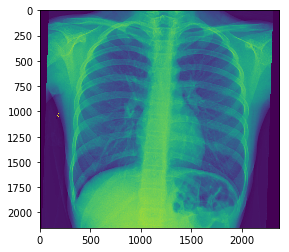

In [7]:
img = plt.imread(f'{PATH}valid/NORMAL/{files[1]}')
plt.imshow(img);

In [8]:
os.makedirs('/cache/tmp', exist_ok=True)
!ln -fs /cache/tmp {PATH}

In [9]:
arch=vgg16
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 2)

100%|██████████| 10/10 [00:18<00:00,  1.87s/it]


epoch      trn_loss   val_loss   accuracy                  
    0      0.186648   0.519438   0.786859  
    1      0.123638   0.55292    0.8125                    



[array([0.55292]), 0.8125000015283242]

In [10]:
data.classes

['NORMAL', 'PNEUMONIA']

In [11]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [12]:
lrf=learn.lr_find()

 89%|████████▉ | 73/82 [00:01<00:00, 45.37it/s, loss=4.22] 


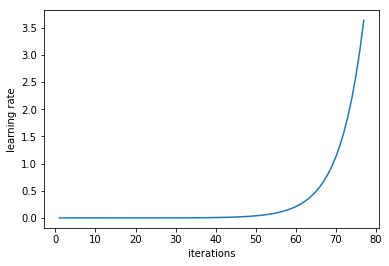

In [13]:
learn.sched.plot_lr()

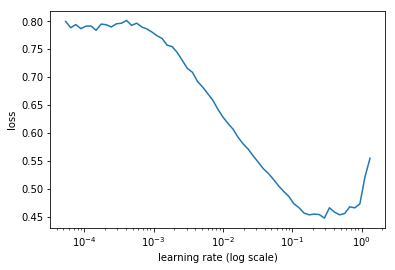

In [14]:
learn.sched.plot()

In [15]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [16]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [17]:
ims = np.stack([get_augs() for i in range(6)])

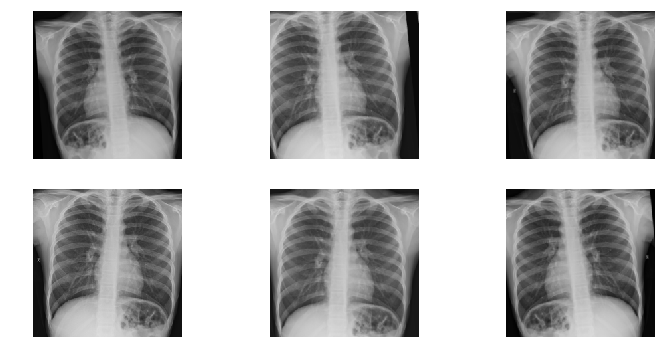

In [18]:
plots(ims, rows=2)

In [19]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [20]:
learn.fit(1e-2, 1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.186777   0.534171   0.802885  



[array([0.53417]), 0.8028846169129397]

In [21]:
learn.precompute=False

In [22]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy                  
    0      0.164577   0.437856   0.842949  
    1      0.163491   0.405797   0.849359                  
    2      0.141482   0.38627    0.86859                   



[array([0.38627]), 0.8685897420614194]

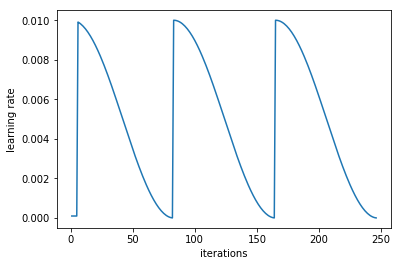

In [23]:
learn.sched.plot_lr()

In [24]:
learn.unfreeze()

In [25]:
lr=np.array([1e-4,1e-3,1e-2])

In [26]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy                  
    0      0.167379   0.425532   0.839744  
    1      0.125868   0.401344   0.855769                  
    2      0.106877   0.400777   0.852564                  
    3      0.096361   0.396333   0.862179                   
    4      0.087478   0.409285   0.863782                   
    5      0.071726   0.324621   0.889423                   
    6      0.07257    0.350015   0.88141                    



[array([0.35001]), 0.8814102548819321]

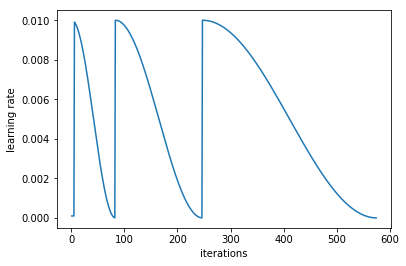

In [27]:
learn.sched.plot_lr()

In [28]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [29]:
accuracy_np(probs, y)

0.8509615384615384

In [30]:
probs[-10:]

array([[0.00071, 0.99929],
       [0.00233, 0.99767],
       [0.00354, 0.99646],
       [0.00135, 0.99865],
       [0.00056, 0.99944],
       [0.00394, 0.99606],
       [0.00251, 0.99749],
       [0.95832, 0.04168],
       [0.00905, 0.99095],
       [0.00171, 0.99829]], dtype=float32)

### Confusion Matrix

In [31]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [32]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[142  92]
 [  1 389]]


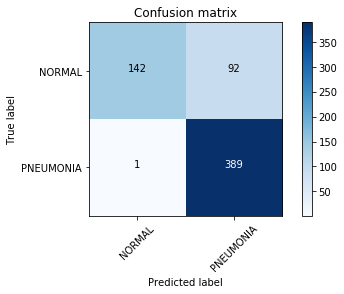

In [33]:
plot_confusion_matrix(cm, data.classes)

### ROC Curve

In [34]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y, probs)

In [35]:
from sklearn.metrics import auc
auc = auc(fpr, tpr)
print(auc)

0.969033530571992


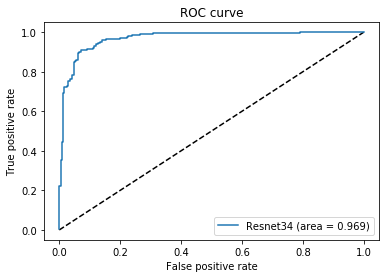

In [36]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Resnet34 (area = {:.3f})'.format(auc))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

In [37]:
print(fpr)

[0.      0.      0.      0.      0.00427 0.00427 0.00855 0.00855 0.01282 0.01282 0.01709 0.01709 0.02564
 0.02564 0.02991 0.02991 0.03419 0.03419 0.03846 0.03846 0.04274 0.04274 0.04701 0.04701 0.05128 0.05128
 0.05556 0.05556 0.05983 0.05983 0.0641  0.0641  0.07265 0.07265 0.07692 0.07692 0.08974 0.08974 0.11111
 0.11111 0.11538 0.11538 0.11966 0.11966 0.12393 0.12393 0.12821 0.12821 0.13248 0.13248 0.14103 0.14103
 0.1453  0.1453  0.15385 0.15385 0.19231 0.19231 0.20085 0.20085 0.21795 0.21795 0.22222 0.22222 0.2265
 0.2265  0.23932 0.23932 0.25214 0.25214 0.26496 0.26496 0.30769 0.30769 0.33761 0.33761 0.7906  0.7906
 1.     ]


In [38]:
print(tpr)

[0.00256 0.07949 0.08462 0.22308 0.22308 0.35128 0.35128 0.44615 0.44615 0.69487 0.69487 0.72308 0.72308
 0.72821 0.72821 0.75128 0.75128 0.76154 0.76154 0.7641  0.7641  0.78205 0.78205 0.84872 0.84872 0.85641
 0.85641 0.86154 0.86154 0.89744 0.89744 0.9     0.9     0.90769 0.90769 0.91026 0.91026 0.91282 0.91282
 0.91795 0.91795 0.93077 0.93077 0.93846 0.93846 0.94103 0.94103 0.94359 0.94359 0.94872 0.94872 0.95897
 0.95897 0.96154 0.96154 0.9641  0.9641  0.96667 0.96667 0.96923 0.96923 0.97179 0.97179 0.97692 0.97692
 0.98205 0.98205 0.98462 0.98462 0.98718 0.98718 0.98974 0.98974 0.99487 0.99487 0.99744 0.99744 1.
 1.     ]


In [39]:
probs[:5]

array([0.09448, 0.63484, 0.97756, 0.24834, 0.84672], dtype=float32)

### Performance Matrix

In [40]:
predict1 = []
for i in range(len(probs)):
    if probs[i] > 0.5:
        predict1.append(1)
    else:
        predict1.append(0)

In [41]:
len(predict1)

624

In [42]:
y_pred = np.array(predict1)

In [43]:
print(sklearn.metrics.classification_report(y_pred, y))

             precision    recall  f1-score   support

          0       0.61      0.99      0.75       143
          1       1.00      0.81      0.89       481

avg / total       0.91      0.85      0.86       624

